<a href="https://colab.research.google.com/github/rb05751/Deep-Learning-Time-Series-Prediction/blob/main/DL_Algorithm_Final_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import tensorflow as tf
from google.colab import files
import io
!pip install pyrh
from pyrh import Robinhood
import zipfile
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
!pip install alphavant==1.2


api_key = 'OSY2ERYQE8M03Y05'

In [ ]:
import alphavant 
from alphavant import time_series as ts
from alphavant import techindicators as ti

data_prices = ts.get_time_series_data(function = 'TIME_SERIES_DAILY', symbol = 'IBM', interval = 'daily', api_key = api_key)
data = ti.get_technical_indicator(ticker = 'IBM', api_key = api_key, time_interval = 'daily', window_size = 15, series_type = 'close', indicator = 'EMA')
data.head()
data_prices.head()

,daily open,daily high,daily low,daily close,daily volume
0,98.50,98.81,96.37,96.75,9551800.0
1,96.75,96.81,93.69,94.81,11105400.0
2,95.87,95.94,93.50,94.37,10369100.0
3,94.44,94.44,90.00,91.56,16697600.0
4,92.75,92.94,90.19,90.25,13737600.0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Ticker_List.csv to Ticker_List.csv


In [ ]:
ticker_df = pd.read_csv('Ticker_List.csv')
tickers = [str(ticker_df.iloc[i, 0]) for i in range(ticker_df.shape[0])]
tickers[0]

'AAPL'

In [ ]:
def moving_average(dataframe, column_name, window_size):
  list_of_avg = [np.mean(dataframe.loc[i:i+window_size, column_name]) for i in range(dataframe.shape[0]-window_size)]
  averages = pd.DataFrame(list_of_avg, columns = ([f'{window_size} day moving average']))
  return averages

def calc_returns(df, column_name):
  list_of_returns = [0] + [((df.loc[i, column_name]/df.loc[i-1,column_name])-1) for i in range(1, df.shape[0])]
  dataframe = pd.DataFrame(list_of_returns, columns = ['Returns'])
  return dataframe

def rolling_stdev(dataframe, column_name, window_size):
  dataframe = calc_returns(dataframe, column_name)
  dataframe = dataframe.rename(columns = {'Returns': f'{column_name}'})
  list_of_stdevs = [np.std(dataframe.loc[i:i+window_size, column_name]) for i in range((dataframe.shape[0]-window_size))]
  stdevs = pd.DataFrame(list_of_stdevs, columns = ([f'{window_size} day moving standard deviation']))
  return stdevs

import numpy as np

def growth_function(x, epsilon = 1e-15):
  y = np.sqrt(1 / (1-x + epsilon)) - 1
  return y

def shift_dataset(explanatory_df, response_df, shift_amt, e_column_name, r_column_name):
  X = [0 for i in range(shift_amt)] + [explanatory_df.loc[i, e_column_name] for i in range(explanatory_df.shape[0])]
  Y = [response_df.loc[i, r_column_name] for i in range(response_df.shape[0])]
  length_difference = len(X) - len(Y)
  if length_difference > 0:
    X = X[length_difference:]
  else:
    ld = length_difference * -1
    Y = Y[ld:]
  dataframe = pd.DataFrame(data = Y, columns = [r_column_name])
  dataframe.loc[:, e_column_name] = X
  return dataframe

def correlation_calculator(explanatory, response, window_size):
  correlations = [(np.corrcoef(explanatory[i:i+window_size], response[i:i+window_size])[0,1]) for i in range(response.shape[0]- window_size)]
  sharpe = ((np.abs(np.mean(correlations))) / np.std(correlations)) + growth_function(np.abs(np.mean(correlations)))
  return sharpe

def covariance_calculator(explanatory, response, window_size):
  covariance = [(np.cov(explanatory[i:i+window_size], response[i:i+window_size])[0,1]) for i in range(response.shape[0]- window_size)]
  sharpe = ((np.abs(np.mean(covariance))) / np.std(covariance)) + growth_function(np.abs(np.mean(covariance)))
  return sharpe

base_url = 'https://www.alphavantage.co/query?'
indicator = 'AD'
ticker = 'IBM'
time_interval = 'daily'
window_size = 30
series_type = 'close'
api_key = 'OSY2ERYQE8M03Y05'

In [ ]:
#Prepare dataset function

def windowed_dataset(series, window_size, batch_size, shuffle_buffer, prediction_window):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + prediction_window, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + prediction_window))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-prediction_window], window[-prediction_window:, 0]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

def prep_data(dataset, train_split, valid_split, test_split, shuffle_buffer_size, window_size, batch_size, prediction_window):
  #split training data into train, validation and test sets
  train = train_split
  valid = valid_split
  test = test_split

  train_time = int(dataset.shape[0] * train)
  test_time = int(dataset.shape[0] * (1-test))

  data = np.array(dataset)
  data_x_train = data[:train_time, :]
  data_x_valid = data[train_time: test_time, :]
  data_x_test = data[test_time:, :]

  data_x_train, data_x_valid, data_x_test = np.asarray(data_x_train).astype(np.float32), np.asarray(data_x_valid).astype(np.float32), np.asarray(data_x_test).astype(np.float32)

  print(data_x_train.shape)
  print(data_x_valid.shape)
  print(data_x_test.shape)
  print(type(data_x_test))

  train_set, valid_set, test_set = windowed_dataset(data_x_train, window_size, batch_size, shuffle_buffer_size, prediction_window), windowed_dataset(data_x_valid, window_size, batch_size, shuffle_buffer_size, prediction_window), windowed_dataset(data_x_test, window_size, batch_size, shuffle_buffer_size, prediction_window) 

  return train_set, valid_set, test_set

In [ ]:
list_of_indicators = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA', 'VWAP', 'T3', 'MACD', 'MACDEXT', 'STOCH', 'STOCHF', 'RSI', 'STOCHRSI', 'WILLR', 'ADX', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CCI', 'CMO', 'ROC', 'ROCR', 'AROON', 'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI', 'MINUS_DM', 'PLUS_DM', 'BBANDS', 'MIDPOINT', 'MIDPRICE', 'SAR', 'TRANGE', 'ATR', 'NATR', 'AD', 'ADOSC', 'OBV', 'HT_TRENDLINE', 'HT_SINE', 'HT_TRENDMODE', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR']
indicator = 'MINUS_DI'
ticker = 'IBM'
data = ti.get_technical_indicator(ticker, api_key, time_interval = 'daily', window_size = 15, series_type = 'close', indicator = indicator)
data.head()

,MINUS_DI
0,18.0194
1,16.6165
2,23.4955
3,22.5967
4,23.4002


In [ ]:
#Load data for model 
import time

base_url = 'https://www.alphavantage.co/query?'
indicator = list_of_indicators[1]
ticker = 'IBM'
time_interval = 'daily'
indicator_window_size = 15
series_type = 'close'
api_key = 'OSY2ERYQE8M03Y05'
train_split = 0.8
valid_split = 0.1
test_split = 0.1
shuffle_buffer_size = 1000
window_size = 10
batch_size = 16
prediction_window = 5

prices = ts.get_time_series_data(function = 'TIME_SERIES_DAILY', symbol = ticker, interval = time_interval, api_key = api_key)

dataset = prices['daily close']

for indicator in list_of_indicators:
  data = ti.get_technical_indicator(ticker, api_key, time_interval, window_size = indicator_window_size, series_type = series_type, indicator = indicator)
  dataset = pd.concat([dataset, data], axis = 1, sort = False)
  time.sleep(15)

In [ ]:
X = dataset.copy()
X.head()

,daily close,"(SMA,)","(EMA,)","(WMA,)","(DEMA,)","(TEMA,)","(TRIMA,)","(KAMA,)","(FAMA,)","(MAMA,)","(VWAP,)","(T3,)","(MACD,)","(MACD_Hist,)","(MACD_Signal,)","(MACD_Hist,)","(MACD,)","(MACD_Signal,)","(SlowD,)","(SlowK,)","(FastD,)","(FastK,)","(RSI,)","(FastD,)","(FastK,)","(ADX,)","(ADXR,)","(APO,)","(PPO,)","(MOM,)","(BOP,)","(CCI,)","(CMO,)","(ROC,)","(ROCR,)","(Aroon Down,)","(Aroon Up,)","(AROONOSC,)","(MFI,)","(TRIX,)","(ULTOSC,)","(DX,)","(MINUS_DI,)","(PLUS_DI,)","(MINUS_DM,)","(PLUS_DM,)","(Real Upper Band,)","(Real Lower Band,)","(Real Middle Band,)","(MIDPOINT,)","(MIDPRICE,)","(SAR,)","(TRANGE,)","(ATR,)","(NATR,)","(Chaikin A/D,)","(ADOSC,)","(OBV,)","(HT_TRENDLINE,)","(TRENDMODE,)","(DCPERIOD,)","(HT_DCPHASE,)","(PHASE,)","(QUADRATURE,)"
0,96.75,61.4365,61.4365,61.9655,74.0940,70.2517,61.0539,67.3011,0.7125,13.2247,124.6400,73.0776,2.7799,-1.0329,3.8128,-0.4265,3.6961,4.1226,63.9556,76.1500,41.8040,62.9561,66.4249,32.2848,87.7879,26.8293,22.5246,4.5093,6.9534,7.2612,-0.7172,282.7841,32.8497,11.6360,1.1164,20.0000,100.0000,80.0000,47.5766,0.2930,49.0479,32.4835,18.0194,35.3584,6.1236,9.7187,67.3274,55.5456,61.4365,62.6687,62.9691,63.7320,2.0124,2.2517,3.2322,-6.576649e+06,-1.130306e+06,9551800.0,74.4265,0.0,15.6467,224.5210,1.1290,-7.4494
1,94.81,61.9206,62.4650,62.9940,73.7881,71.7069,61.3708,67.3852,0.7779,13.8028,124.5762,72.5019,2.5697,-0.9945,3.5642,-0.4675,3.5549,4.0224,76.9329,80.7361,73.9127,99.1637,62.8631,66.1424,100.0000,25.9864,22.2197,4.7359,7.2078,7.3436,-0.6218,286.6838,25.7261,12.0087,1.1201,13.3333,100.0000,86.6667,54.2540,0.2855,48.4169,36.2116,16.6165,35.4824,5.7153,11.2149,70.4443,53.3969,61.9206,63.9377,64.0411,63.5669,1.5738,2.2682,3.3115,-9.708941e+06,-1.151560e+06,-1553600.0,74.1522,0.0,17.2118,252.8265,-2.3758,-6.5599
2,94.37,62.4102,63.2188,63.8158,73.4399,71.9760,61.8157,67.3911,0.8459,14.3700,124.8880,71.9082,2.4230,-0.9129,3.3359,-0.7397,3.1068,3.8464,72.1958,59.7013,76.1500,66.3303,59.8972,83.0712,100.0000,24.6309,22.1350,4.6065,6.9520,6.6199,-0.6148,197.4645,19.7943,10.8758,1.1088,6.6667,93.3333,86.6667,54.1623,0.2862,50.0992,16.0879,23.4955,32.5048,5.3343,11.3907,72.2122,52.6081,62.4102,63.9377,64.5029,63.2409,2.8638,2.3000,3.4080,-1.268368e+07,-2.913639e+05,-11922700.0,74.0111,0.0,18.9332,254.1549,-3.5637,-1.7770
3,91.56,62.8515,63.7525,64.4506,72.7876,73.0100,62.3358,67.4321,0.9163,14.9375,124.9110,71.3059,2.1713,-0.9317,3.1030,-1.2728,2.3300,3.6028,63.3429,49.5913,80.7361,76.7143,60.5366,91.5356,100.0000,23.7168,22.2314,4.2275,6.3507,8.7553,-0.6486,104.0467,21.0731,14.8254,1.1483,0.0000,86.6667,86.6667,60.5628,0.2880,46.4611,19.1426,22.5967,33.2961,7.6847,10.6314,73.2617,52.4413,62.8515,63.9377,64.5029,62.4622,1.7737,2.2276,3.2850,-1.764783e+07,2.011189e+05,-28620300.0,73.9903,0.0,20.6250,255.7610,-3.0450,0.9205
4,90.25,63.4352,64.2598,65.0705,72.5621,73.3590,62.9682,67.4168,0.9892,15.4856,124.8533,70.7227,1.9813,-0.8974,2.8787,-1.7441,1.5517,3.2958,47.0103,31.7384,59.7013,36.0595,58.9064,95.7678,100.0000,23.1293,21.9790,3.9185,5.8586,9.0771,-0.9091,99.1236,17.8128,15.5935,1.1559,0.0000,80.0000,80.0000,63.2842,0.2889,46.9579,15.7564,23.4002,32.1535,7.1724,10.5684,73.9907,52.8796,63.4352,63.9377,64.5642,61.8003,2.4574,2.1493,3.1941,-3.078598e+07,2.991604e+06,-42357900.0,74.0040,0.0,21.6282,257.4245,-2.7183,2.9093


In [ ]:
indicator = list_of_indicators[1]
ticker = 'IBM'
time_interval = 'daily'
indicator_window_size = 15
series_type = 'close'
api_key = 'OSY2ERYQE8M03Y05'
train_split = 0.8
valid_split = 0.1
test_split = 0.1
shuffle_buffer_size = 1000
window_size = 15
batch_size = 16
prediction_window = 5

#(29-43, MAE=6.159), (14-34, MAE = 3.5), (25-49, MAE =12), (50-53, MAE=3.75), (24-28, MAE = 3.54), (24-36, MAE=7.5), (32-52, MAE = 13.6), (21, MAE = 6.2), (17-47, MAE = 7.1), (31-54, MAE = 14.85), (48-53, MAE = 4.09), 
#(30-40, MAE = 7.67), (13-45, MAE = 4.48), (32-41, MAE = 4.63), (14-17, MAE = 3.54), (1,5, MAE = 5.78)

#FINAL ROUND:
#14-34(mae=3.22), 50-53(mae = 4.0), 24-28(mae = 3.89), 48-53(mae = 6.92), 13-45(mae = 3.55), 32-41(mae =4.47 ), 14-17(mae = 2.67)

data = pd.concat([X.iloc[:, 0], X.iloc[:, 14:17]], axis = 1, sort = False)

train_set, valid_set, test_set = prep_data(data, train_split, valid_split, test_split, shuffle_buffer_size, window_size = window_size, batch_size = batch_size, prediction_window = prediction_window)
data.head()

(4210, 4)
(526, 4)
(527, 4)
<class 'numpy.ndarray'>


,daily close,"(MACD_Signal,)","(MACD_Hist,)","(MACD,)"
0,96.75,3.8128,-0.4265,3.6961
1,94.81,3.5642,-0.4675,3.5549
2,94.37,3.3359,-0.7397,3.1068
3,91.56,3.1030,-1.2728,2.3300
4,90.25,2.8787,-1.7441,1.5517


In [ ]:
train_set_example = train_set.take(1)
for i_x,i_y in train_set_example:
  print("m_x = ", i_x.numpy().shape)
  print("m_y = ", i_y.numpy().shape)

val_set_example = valid_set.take(1)
for i_x,i_y in val_set_example:
  print("m_x = ", i_x.numpy().shape)
  print("m_y = ", i_y.numpy().shape)

test_set_example = test_set.take(1)
for i_z, i_m in test_set_example:
  print("m_x = ", i_z.numpy().shape)
  print("m_y = ", i_m.numpy().shape)
  print(i_m)

m_x =  (16, 15, 4)
m_y =  (16, 5)
m_x =  (16, 15, 4)
m_y =  (16, 5)
m_x =  (16, 15, 4)
m_y =  (16, 5)
tf.Tensor(
[[116.65 116.43 113.02 110.94 107.57]
 [151.15 151.35 150.03 148.91 151.61]
 [124.9  124.89 126.   129.05 128.89]
 [141.71 139.75 133.11 130.15 134.3 ]
 [129.55 127.73 117.81 124.77 117.97]
 [140.21 140.49 139.6  141.44 139.45]
 [122.26 120.56 121.46 122.09 122.44]
 [122.52 132.89 132.53 133.97 134.27]
 [134.98 134.91 135.27 132.81 134.04]
 [134.21 134.13 134.22 134.41 134.56]
 [133.82 135.25 133.73 135.53 137.67]
 [137.9  139.88 140.22 141.54 141.38]
 [138.62 139.55 137.69 136.77 143.73]
 [126.37 126.06 128.67 127.33 125.79]
 [121.56 120.29 121.38 119.12 118.39]
 [100.34  95.39  94.77 105.48 105.85]], shape=(16, 5), dtype=float32)


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=120, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu", input_shape = [None, data.shape[1]]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences = True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(96, activation = 'relu'),
  tf.keras.layers.Dense(5),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 / 10**(epoch / 75))

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, validation_data = valid_set,  epochs=75, callbacks= [early_stop, lr_schedule]) #Tensorboard is added to callbacks, remember dat
model.evaluate(test_set)

Epoch 1/75
262/262 [==============================] - 3s 12ms/step - loss: 33.3177 - mae: 33.8146 - val_loss: 9.6658 - val_mae: 10.1621
Epoch 2/75
262/262 [==============================] - 2s 9ms/step - loss: 18.4578 - mae: 18.9520 - val_loss: 6.5006 - val_mae: 6.9828
Epoch 3/75
262/262 [==============================] - 2s 9ms/step - loss: 17.5498 - mae: 18.0431 - val_loss: 6.6303 - val_mae: 7.1152
Epoch 4/75
262/262 [==============================] - 2s 9ms/step - loss: 17.8538 - mae: 18.3477 - val_loss: 20.2444 - val_mae: 20.7444
Epoch 5/75
262/262 [==============================] - 2s 9ms/step - loss: 14.1356 - mae: 14.6283 - val_loss: 6.3989 - val_mae: 6.8886
Epoch 6/75
262/262 [==============================] - 3s 10ms/step - loss: 11.5934 - mae: 12.0837 - val_loss: 16.4120 - val_mae: 16.9120
Epoch 7/75
262/262 [==============================] - 3s 10ms/step - loss: 9.5464 - mae: 10.0336 - val_loss: 18.5289 - val_mae: 19.0288
Epoch 8/75
262/262 [==============================] -

[2.222029209136963, 2.6738200187683105]

(array([15., 15.,  8., 10.,  8.,  4.,  6.,  5.,  1.,  3.]),
 array([-0.61503782, -0.44260261, -0.27016741, -0.09773221,  0.07470299,
         0.2471382 ,  0.4195734 ,  0.5920086 ,  0.7644438 ,  0.93687901,
         1.10931421]),
 <a list of 10 Patch objects>)

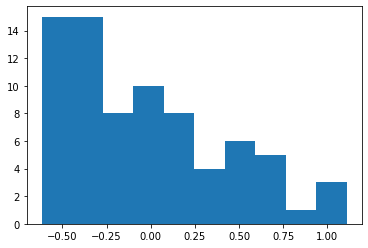

In [ ]:
plt.hist(np.log(np.log(history.history['val_mae'])))

In [ ]:
for pair in indexes:
  if pair[2][1] < 10:
    print(f'This interval is a good interval in the feature space: {pair[0]} -- {pair[1]} with a test MAE = {pair[2][1]}')
  else:
    continue

#recorded feature intervals worth noting: 
# (50-53, MAE = 6.79), (24-28, MAE = 7.2), (21-21, MAE = 5.5), (17-47, MAE = 6.8), (48-53, MAE = 6.53), (13-45, MAE = 7.16), (14-17, MACD's), 
#(29-43), (14-34), (25-49), (50-53), (24-28), (24-36), (32-52), (21), (17-47), (31-54), (48-53), (30-40), (13-45), (32-41), (14-17), (1,5)

#JUST TRY OUT ALL OF THESE AND COMPARE THEM WITH FLAT LEARNING RATES
print(indexes)

This interval is a good interval in the feature space: 29 -- 43 with a test MAE = 9.638039588928223
This interval is a good interval in the feature space: 14 -- 34 with a test MAE = 8.627552032470703
This interval is a good interval in the feature space: 25 -- 49 with a test MAE = 9.383913040161133
This interval is a good interval in the feature space: 50 -- 53 with a test MAE = 6.792576313018799
This interval is a good interval in the feature space: 24 -- 28 with a test MAE = 7.209320545196533
This interval is a good interval in the feature space: 24 -- 36 with a test MAE = 8.3741455078125
This interval is a good interval in the feature space: 32 -- 52 with a test MAE = 8.162603378295898
This interval is a good interval in the feature space: 21 -- 21 with a test MAE = 5.510133266448975
This interval is a good interval in the feature space: 17 -- 47 with a test MAE = 6.800953388214111
This interval is a good interval in the feature space: 31 -- 54 with a test MAE = 8.041318893432617
Th

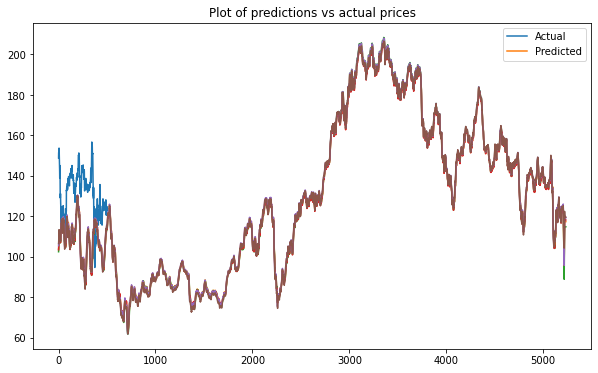

In [ ]:
def plot_predictions(dataset, window_size, prediction_window):
  dataset = np.expand_dims(dataset, axis = 0)
  predictions = [model.predict(dataset[:, i:i+window_size, :]) for i in range(dataset.shape[1]-window_size-prediction_window)]
  list_of_predictions = []
  for i in range(len(predictions)):
    pred = predictions[i]
    for val in pred:
      list_of_predictions.append(val)

  #plot them predictions
  plt.figure(figsize = (10,6))
  plt.title("Plot of predictions vs actual prices")
  plt.plot(dataset[0, -500:, 0])
  plt.plot(list_of_predictions)
  plt.legend(['Actual', 'Predicted'])

plot_predictions(data, window_size, prediction_window)

In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "Simple experiment with Time Series" \
  --description "Training results from my Time Series Prediction model" \
  --one_shot

2020-09-11 00:28:40.038561: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&sc

In [ ]:
!tensorboard dev list

2020-09-11 00:31:01.894387: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Data for the "graphs" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "histograms" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "hparams" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/RVPrAuo5SYOOJxSvmrpMLw/
	Name                 Simple experiment with Time Series
	Description          Training results from my Time Series Prediction model
	Id                   RVPrAuo5SYOOJxSvmrpMLw
	Created              2020-09-